# Importing Libs

In [480]:
import pandas as pd
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

path_project = "/home/igorcosta/PycharmProjects/football/"
sys.path.insert(1, path_project)
from core.config_loader import SysConfig

# Betting Strategies

In [464]:
CHAMPIONSHIP = 'm.ss.ch.nm'
RESULT = 'm.res.bts'
MODEL_PREDICTION = 'pred'
MARKET_PREDICTION = 'm.odds.f.bts.f.c'
MODEL_PROB_Y = 'pred_prob_y'
MODEL_PROB_N = 'pred_prob_n'

Y_ODD_MAX = 'm.odds.s.bts.y.o.max'
N_ODD_MAX = 'm.odds.s.bts.n.o.max'

Y_ODD_AVG = 'm.odds.s.bts.y.o.avg'
N_ODD_AVG = 'm.odds.s.bts.n.o.avg'

Y_PROB_AVG = 'm.odds.s.bts.y.t.avg'
N_PROB_AVG = 'm.odds.s.bts.n.t.avg'

BET_PR_BTS = 'bet.pred.res'
BET_EV_BTS = 'bet.ev.res'
BET_KC_BTS = 'bet.kc.res'

BET_PR_HIT = 'bet.pred.hit'
BET_EV_HIT = 'bet.ev.hit'
BET_KC_HIT = 'bet.kc.hit'

BET_PR_PL_AVG = 'bet.pred.pl.avg'
BET_EV_PL_AVG = 'bet.ev.pl.avg'
BET_KC_PL_AVG = 'bet.kc.pl.avg'

BET_PR_PL_MAX = 'bet.pred.pl.max'
BET_EV_PL_MAX = 'bet.ev.pl.max'
BET_KC_PL_MAX = 'bet.kc.pl.max'

BET_KC_VAL_Y_AVG = 'bet.kc.val.y.avg'
BET_KC_VAL_N_AVG = 'bet.kc.val.n.avg'

BET_KC_VAL_Y_MAX = 'bet.kc.val.y.max'
BET_KC_VAL_N_MAX = 'bet.kc.val.n.max'

BET_KC_PL_Y_AVG = 'bet.kc.pl.y.avg'
BET_KC_PL_N_AVG = 'bet.kc.pl.n.avg'

BET_KC_PL_Y_MAX = 'bet.kc.pl.y.max'
BET_KC_PL_N_MAX = 'bet.kc.pl.n.max'

In [465]:
def bet_on_predicted(data):
    data[BET_PR_BTS] = data[MODEL_PREDICTION]
    data[BET_PR_HIT] = data[BET_PR_BTS] == data[RESULT]
    data[BET_PR_PL_AVG] = np.where(data[BET_PR_HIT] == True, 
                                   (np.where(data[BET_PR_BTS] == 'y', data[Y_ODD_AVG]-1, data[N_ODD_AVG]-1)), -1)
    
    data[BET_PR_PL_MAX] = np.where(data[BET_PR_HIT] == True, 
                                   (np.where(data[BET_PR_BTS] == 'y', data[Y_ODD_MAX]-1, data[N_ODD_MAX]-1)), -1)

def bet_with_expected_value(data):
    
    data[BET_EV_BTS] = np.where(data[MODEL_PROB_Y] > data[Y_PROB_AVG], 'y', 
                          (np.where(data[MODEL_PROB_Y] < data[Y_PROB_AVG], 'n', data[MARKET_PREDICTION])))
    
    data[BET_EV_HIT] = data[BET_EV_BTS] == data[RESULT]
    data[BET_EV_PL_AVG] = np.where(data[BET_EV_HIT] == True, 
                                   (np.where(data[BET_EV_BTS] == 'y', data[Y_ODD_AVG]-1, data[N_ODD_AVG]-1)), -1)
    
    data[BET_EV_PL_MAX] = np.where(data[BET_EV_HIT] == True, 
                                   (np.where(data[BET_EV_BTS] == 'y', data[Y_ODD_MAX]-1, data[N_ODD_MAX]-1)), -1)

def bet_with_kelly_criterion(data):
    
    data[BET_KC_VAL_Y_AVG] = ((data[Y_ODD_AVG]-1)*data[MODEL_PROB_Y]-data[MODEL_PROB_N])/(data[Y_ODD_AVG]-1)
    data[BET_KC_VAL_N_AVG] = ((data[N_ODD_AVG]-1)*data[MODEL_PROB_N]-data[MODEL_PROB_Y])/(data[N_ODD_AVG]-1)
    data[BET_KC_VAL_Y_MAX] = ((data[Y_ODD_MAX]-1)*data[MODEL_PROB_Y]-data[MODEL_PROB_N])/(data[Y_ODD_MAX]-1)
    data[BET_KC_VAL_N_MAX] = ((data[N_ODD_MAX]-1)*data[MODEL_PROB_N]-data[MODEL_PROB_Y])/(data[N_ODD_MAX]-1)
    
        
    data[BET_KC_PL_Y_AVG] = np.where(data[BET_KC_VAL_Y_AVG] > 0, 
                                         (np.where(data[RESULT] == 'y', 
                                                   data[BET_KC_VAL_Y_AVG]*(data[Y_ODD_AVG]-1), 
                                                   -data[BET_KC_VAL_Y_AVG])), 0)
    data[BET_KC_PL_N_AVG] = np.where(data[BET_KC_VAL_N_AVG] > 0, 
                                         (np.where(data[RESULT] == 'n', 
                                                   data[BET_KC_VAL_N_AVG]*(data[N_ODD_AVG]-1), 
                                                   -data[BET_KC_VAL_N_AVG])), 0)
        
    data[BET_KC_PL_Y_MAX] = np.where(data[BET_KC_VAL_Y_MAX] > 0, 
                                         (np.where(data[RESULT] == 'y', 
                                                   data[BET_KC_VAL_Y_MAX]*(data[Y_ODD_MAX]-1), 
                                                   -data[BET_KC_VAL_Y_MAX])), 0)
        
    data[BET_KC_PL_N_MAX] = np.where(data[BET_KC_VAL_N_MAX] > 0, 
                                         (np.where(data[RESULT] == 'n', 
                                                   data[BET_KC_VAL_N_MAX]*(data[N_ODD_MAX]-1), 
                                                   -data[BET_KC_VAL_N_MAX])), 0)
        

    data[BET_KC_PL_AVG] = data[BET_KC_PL_Y_AVG] + data[BET_KC_PL_N_AVG]
    data[BET_KC_PL_MAX] = data[BET_KC_PL_Y_MAX] + data[BET_KC_PL_N_MAX]


In [466]:
def set_pl_pr(pl, data, row, col):

    vavg = data[BET_PR_PL_AVG].sum()
    vmax = data[BET_PR_PL_MAX].sum()
    
    pl.loc[row, '_'.join([col, 'AVG'])] = vavg
    pl.loc[row, '_'.join([col, 'MAX'])] = vmax
    pl.loc[row, '_'.join([col, 'AVG', 'ROI'])] = vavg/len(data)*100
    pl.loc[row, '_'.join([col, 'MAX', 'ROI'])] = vmax/len(data)*100
    
def set_pl_ev(pl, data, row, col):

    pl.loc[row, '_'.join([col, 'AVG'])] = data[BET_EV_PL_AVG].sum()
    pl.loc[row, '_'.join([col, 'MAX'])] = data[BET_EV_PL_MAX].sum()
    pl.loc[row, '_'.join([col, 'AVG', 'ROI'])] = data[BET_EV_PL_MAX].sum()*100/len(data)
    pl.loc[row, '_'.join([col, 'MAX', 'ROI'])] = data[BET_EV_PL_MAX].sum()*100/len(data)
    
def set_pl_kc(pl, data, row, col):
    
    temp_y_avg = data[data[BET_KC_VAL_Y_AVG] > 0]
    temp_n_avg = data[data[BET_KC_VAL_N_AVG] > 0]
    temp_y_max = data[data[BET_KC_VAL_Y_MAX] > 0]
    temp_n_max = data[data[BET_KC_VAL_N_MAX] > 0]
    
    tavg = temp_y_avg[BET_KC_VAL_Y_AVG].sum() + temp_n_avg[BET_KC_VAL_N_AVG].sum()
    tmax = temp_y_max[BET_KC_VAL_Y_MAX].sum() + temp_n_max[BET_KC_VAL_N_MAX].sum()
    
    pl.loc[row, '_'.join([col, 'AVG'])] = data[BET_KC_PL_AVG].sum()
    pl.loc[row, '_'.join([col, 'MAX'])] = data[BET_KC_PL_MAX].sum()
    pl.loc[row, '_'.join([col, 'AVG', 'ROI'])] = data[BET_KC_PL_AVG].sum()*100/tavg
    pl.loc[row, '_'.join([col, 'MAX', 'ROI'])] = data[BET_KC_PL_MAX].sum()*100/tmax

In [468]:
exp1 = ['performance', 'gw']
exp2 = ['market','gw']
exp3 = ['total', 'gw']
exps = [exp2, exp3]

frame = list()
pl = pd.DataFrame()
pl_champ = pd.DataFrame()
for c in ['XGBClassifier', 'GaussianNB','LogisticRegression','mkc']:
    for e in exps:            
        filename = 'test.csv'
        pred_dir = os.path.join(SysConfig.experiments('btts'), e[0], e[1], c, 'predictions')
        pred_file = os.path.join(pred_dir, filename)

        with open(pred_file, 'r') as outfile:
            data = pd.read_csv(outfile)

        bet_on_predicted(data)
        bet_with_expected_value(data)
        bet_with_kelly_criterion(data)
               
        with open(pred_file, 'w') as outfile:
            data.to_csv(outfile, index=False)

        set_pl_pr(pl, data, c, '_'.join([e[0], 'PR']) )
        set_pl_ev(pl, data, c, '_'.join([e[0], 'EV']) )
        set_pl_kc(pl, data, c, '_'.join([e[0], 'KC']) )
        
        for ch in ['Brazil A', 'Brazil B', 'France A', 
                   'Portugal A', 'Italy A', 'Netherlands A', 'Spain A', 'Germany A', 'England A']:
            
            data_champ = data[data[CHAMPIONSHIP] == ch]
            set_pl_pr(pl_champ, data_champ, ch, '_'.join([c, e[0], 'PR']) )
            set_pl_ev(pl_champ, data_champ, ch, '_'.join([c, e[0], 'EV']) )
            set_pl_kc(pl_champ, data_champ, ch, '_'.join([c, e[0], 'KC']) )

pl_champ.loc["total"] = pl_champ.sum()

/home/igorcosta/anaconda3/envs/football/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


# Profit/Loss

In [469]:
def get_matrix_pl(e, c, col):
    filename = 'test.csv'
    pred_dir = os.path.join(SysConfig.experiments('btts'), e[0], e[1], c, 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)
        
    profit = pd.DataFrame()
    for i in range(30,71):
        for j in range(i,71):
            temp = data[data['m.odds.s.bts.y.t.avg'] >= i/100]
            temp = temp[temp['m.odds.s.bts.y.t.avg'] <= j/100]
            profit.loc[i/100, j/100] = temp[col].sum()

    return profit

In [470]:
mats_pr = dict()
for c in ['XGBClassifier', 'GaussianNB','LogisticRegression','mkc']:
    for e in exps:
        mat = get_matrix_pl(e, c, BET_PR_PL_MAX)
        col = "_".join([c,e[0]])
        mats_pr[col] = mat

In [471]:
mats_ev = dict()
for c in ['XGBClassifier', 'GaussianNB','LogisticRegression','mkc']:
    for e in exps:
        mat = get_matrix_pl(e, c, BET_EV_PL_MAX)
        col = "_".join([c,e[0]])
        mats_ev[col] = mat

In [472]:
mats_kc = dict()
for c in ['XGBClassifier', 'GaussianNB','LogisticRegression','mkc']:
    for e in exps:
        mat = get_matrix_pl(e, c, BET_KC_PL_MAX)
        col = "_".join([c,e[0]])
        mats_kc[col] = mat

In [473]:
def plot_mats(mats):
    
    fig = plt.figure(figsize=(15,5))
    grid = AxesGrid(fig, 111,
                    nrows_ncols=(1, 4),
                    axes_pad=0.2,
                    cbar_location="right",
                    cbar_mode="single",
                    )

    for ax, m in zip(grid, mats):

        label = m.split('_')[0]
        hm = ax.imshow(mats[m])
        ax.set_title(label)
        ax.set_yticks([1,10,20,30,40])
        ax.set_xticks([1,10,20,30,40])
        ax.set_yticklabels([.3,.4,.5,.6,.7,.8])
        ax.set_xticklabels([.3,.4,.5,.6,.7,.8])

    #ticks=np.arange(-200,200,10)
    cbar = grid.cbar_axes[0].colorbar(hm)
    plt.show()

# EXPERIMENT 2: MARKET (MAX ODDS)

In [512]:
cols_market = [i for i in mats_pr.keys() if 'market' in i] 

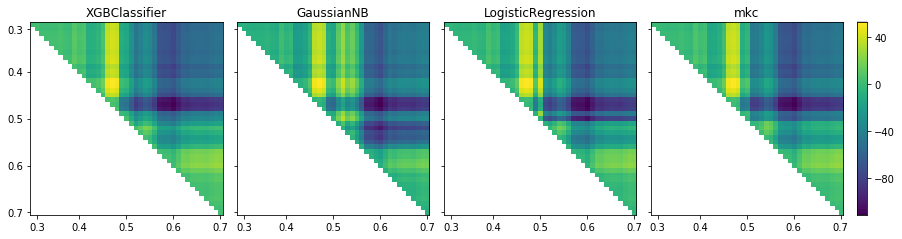

In [513]:
mats = mats_pr
mats = dict((k,mats[k]) for k in cols_market if k in mats)
plot_mats(mats)

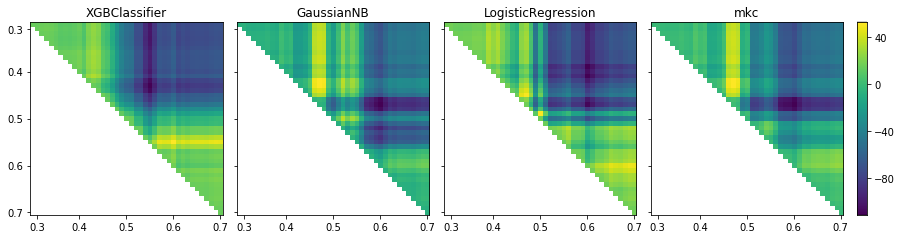

In [514]:
mats = mats_ev
mats = dict((k,mats[k]) for k in cols_market if k in mats)
plot_mats(mats)

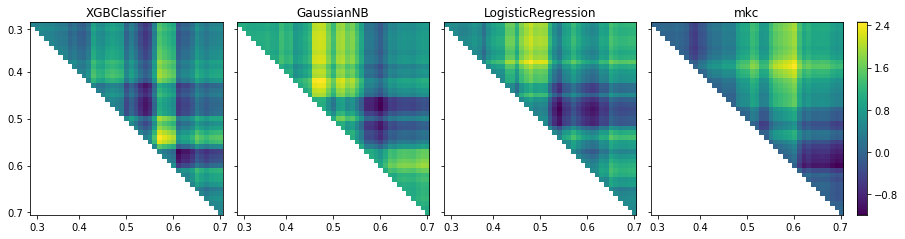

In [515]:
mats = mats_kc
mats = dict((k,mats[k]) for k in cols_market if k in mats)
plot_mats(mats)

# EXPERIMENT 3: TOTAL (MAX ODDS)

In [516]:
cols_total = [i for i in mats_pr.keys() if 'total' in i] 

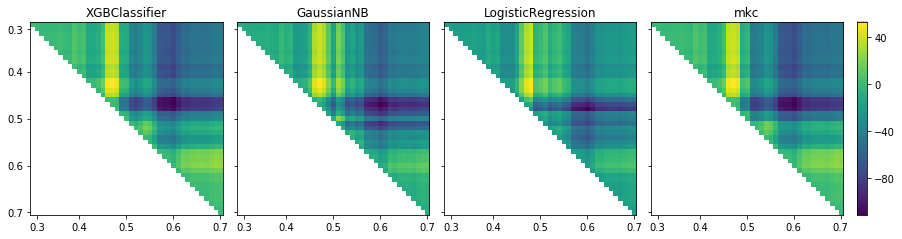

In [517]:
mats = mats_pr
mats = dict((k,mats[k]) for k in cols_total if k in mats)
plot_mats(mats)

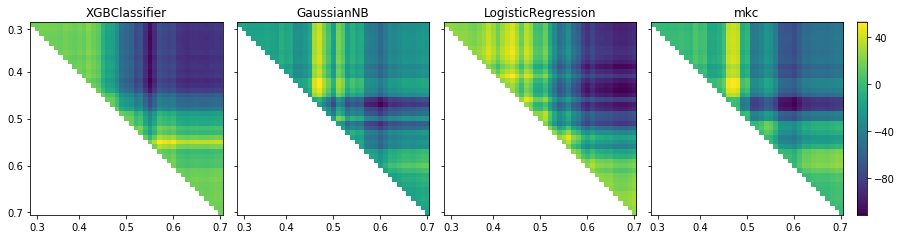

In [520]:
mats = mats_ev
mats = dict((k,mats[k]) for k in cols_total if k in mats)
plot_mats(mats)

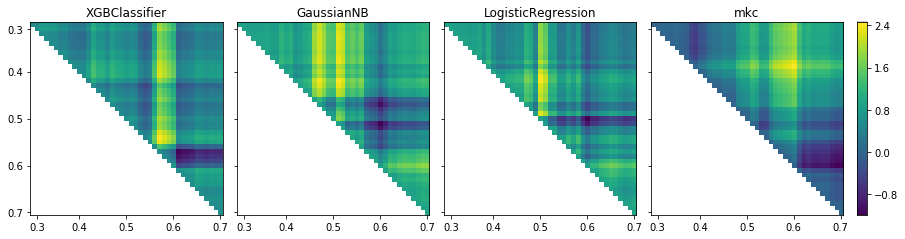

In [521]:
mats = mats_kc
mats = dict((k,mats[k]) for k in cols_total if k in mats)
plot_mats(mats)

In [ ]:
mats = mats_pr
from mpl_toolkits.axes_grid1 import AxesGrid
fig = plt.figure(figsize=(15,5))
grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 4),
                axes_pad=0.2,
                cbar_location="right",
                cbar_mode="single",
                )

for ax, m in zip(grid, mats):
    
    label = m.split('_')[0]
    hm = ax.imshow(mats[m])
    ax.set_title(label)
    ax.set_yticks([1,10,20,30,40])
    ax.set_xticks([1,10,20,30,40])
    ax.set_yticklabels([.3,.4,.5,.6,.7,.8])
    ax.set_xticklabels([.3,.4,.5,.6,.7,.8])
    
cbar = grid.cbar_axes[0].colorbar(hm, ticks=np.arange(-200,80,10))
plt.show()

In [309]:
exp1 = ['performance', 'gw']
exp2 = ['market','gw']
exp3 = ['total', 'gw']
exps = [exp2, exp3]

frame = list()
for c in ['XGBClassifier', 'GaussianNB','LogisticRegression','mkc']:
    for e in exps:
        for ch in ['Brazil A', 'Brazil B', 'France A', 
                   'Portugal A', 'Italy A', 'Netherlands A', 'Spain A', 'Germany A', 'England A',
                   'total']:
            
            filename = ch + '.json'
            score_dir = os.path.join(SysConfig.experiments('btts'), e[0], e[1], c, 'results')
            score_file = os.path.join(score_dir, filename)
            
            with open(score_file, 'r') as outfile:
                data = outfile.read()
                res = json.loads(data)
            t = res['test']
            frame.append([c, e[0], ch, t['acc'], 
                          t['rps'], t['mae'], t['brier_score_loss'],
                          t['log_loss'], t['roc_auc_score'], t['f1_score']])
            
resume = pd.DataFrame(frame, columns=['classifier','features', 'championship', 'acc','rps', 'mae', 'bsl',
                                    'logloss', 'auc', 'f1'])

In [477]:
cols = [i for i in pl.columns if 'MAX' in i]
print(pl[cols])

                    market_PR_MAX  market_PR_MAX_ROI  market_EV_MAX  \
XGBClassifier              -56.02          -0.876271        -142.85   
GaussianNB                 -28.61          -0.447521         -29.42   
LogisticRegression         -34.47          -0.539183         -64.77   
mkc                        -44.08          -0.689504         -44.08   

                    market_EV_MAX_ROI  market_KC_MAX  market_KC_MAX_ROI  \
XGBClassifier               -2.234475      -0.425946          -0.295622   
GaussianNB                  -0.460191      -5.057724          -0.157956   
LogisticRegression          -1.013139       0.421333           0.671339   
mkc                         -0.689504       0.580552           0.989993   

                    total_PR_MAX  total_PR_MAX_ROI  total_EV_MAX  \
XGBClassifier             -42.20         -0.660097       -190.04   
GaussianNB                -26.16         -0.409198         -7.07   
LogisticRegression         -0.31         -0.004849        -93.52

In [478]:
cols = [i for i in pl_champ.columns if 'MAX_ROI' in i]
print(pl_champ[cols])

               XGBClassifier_market_PR_MAX_ROI  \
Brazil A                              6.758575   
Brazil B                             -5.781579   
France A                             -6.176316   
Portugal A                           -1.157119   
Italy A                              -1.828947   
Netherlands A                         1.844771   
Spain A                               0.260526   
Germany A                             2.619281   
England A                            -3.250000   
total                                -6.710808   

               XGBClassifier_market_EV_MAX_ROI  \
Brazil A                             -4.630607   
Brazil B                             -0.010526   
France A                             -3.739474   
Portugal A                            1.597381   
Italy A                              -0.807895   
Netherlands A                        -3.039216   
Spain A                              -2.876316   
Germany A                            -3.325163   

In [479]:
for ch in ['Brazil A', 'Brazil B', 'France A', 
           'Portugal A', 'Italy A', 'Netherlands A', 'Spain A', 'Germany A', 'England A',
           'total']:
    print(ch)
    temp = resume[resume['championship'] == ch]
    f = 'acc'
    print(temp)
    print(temp[['classifier','features','bsl', f]])
    print("----")

Brazil A
            classifier features championship       acc       rps       mae  \
0        XGBClassifier   market     Brazil A  0.576517  0.122899  0.494399   
10       XGBClassifier    total     Brazil A  0.577836  0.122910  0.494494   
20          GaussianNB   market     Brazil A  0.573879  0.134129  0.462451   
30          GaussianNB    total     Brazil A  0.556728  0.146184  0.457546   
40  LogisticRegression   market     Brazil A  0.580475  0.122495  0.492874   
50  LogisticRegression    total     Brazil A  0.567282  0.123060  0.492958   
60                 mkc   market     Brazil A  0.576517  0.122677  0.493706   
70                 mkc    total     Brazil A  0.576517  0.122677  0.493706   

         bsl   logloss       auc        f1  
0   0.245797  0.684738  0.586697  0.421622  
10  0.245819  0.684777  0.586592  0.416058  
20  0.268257  0.765536  0.584358  0.481541  
30  0.292368  0.892052  0.579385  0.505882  
40  0.244989  0.683110  0.584169  0.451724  
50  0.246121  0.68